In [64]:
import time
import re
from tqdm import tqdm
import os
import sys
import math
from pprint import pprint as pp

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import csv
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Dropout ,MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import glob

sys.path.append('../..') #add root directory of project to import needed modules

from src.train_model import train_model
from src.evaluate_model import evaluate_model
from src.utils.general import load_yaml, save_yaml
from src.utils.metrics import compute_metrics
from src.utils.pipeline import load_model, build_data_loader, freeze_layers
from src.utils.post_processing import aggregate_detailed_classes, aggregate_obj_results
from src.analysis.mistakes import show_mistakes_by_target, show_mistakes_by_pred, plot_proba_distr

from src.collection import CollectionAttention, CollectionSeparate
from src.models.densenet import densenet121, DenseNetAttn
from src.models.efficeintnet import EfficientnetB3AttnPretrained, EfficientnetB3Pretrained, EfficientnetB3
from src.models.mobilenet import MobileNetV2_
from src.models.resnet import ResNet50
from src.train import TrainerAttention, TrainerSeparate

from etc.alrosa.utils import get_values
from sklearn.svm import SVC
 # Disable warnings print
import warnings
warnings.filterwarnings('ignore')

In [76]:
path='C:/Users/getbb/Documents/classification_pipeline/images'
classnames=[]
def forming_csv() :
    with open("C:/Users/getbb/Documents/classification_pipeline/samples/full.csv", mode="w", encoding='utf-8') as w_file :
            file_writer = csv.writer(w_file, delimiter = ",", lineterminator="\r")
            file_writer.writerow(["obj_id","class_name", "img_path", "target"])
            i=0
            j=-1
            for foldername in os.listdir(path): 
                classname=foldername
                for names in glob.glob(os.path.join(path+'/'+foldername, '*.jpg')):
                    names=names.replace("\\",'/')
                    if classname in classnames :
                        file_writer.writerow([i,classname,names,j])
                    else :
                        classnames.append(classname)
                        j+=1
                        file_writer.writerow([i,classname,names,j])
                    i+=1
                    
forming_csv()

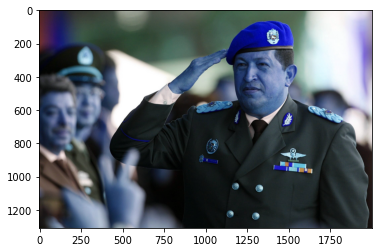

In [77]:
images = pd.read_csv('C:/Users/getbb/Documents/classification_pipeline/samples/full.csv')
def load_and_split_data(data) :
    x_train=[]  
    y_train=[]
    x_test=[]
    y_test=[]
    seed=10
    cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    gems = images.groupby(['obj_id'])['target'].first().reset_index()
    train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.16, random_state=seed)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,  scaleFactor=1.2, minNeighbors=5,minSize=(20, 20)  )
        if len(faces)>1 :
            plt.figure()
            plt.imshow(img)
            os.remove(images['img_path'][i])
        for (x, y, w, h) in faces:
            x_train.append(img[y: y + h, x: x + w])
    return 
load_and_split_data(images)


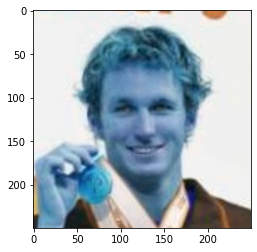

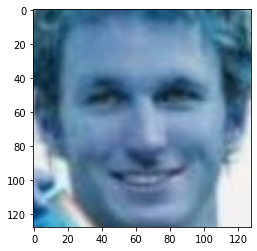

In [82]:
cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)
img = cv2.imread('C:/Users/getbb/PycharmProjects/praktika/training-images/Aaron_Peirsol/Aaron_Peirsol_0001.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(
        gray,               #
        scaleFactor=1.2,    #
        minNeighbors=1,     #
        minSize=(10, 10)    #
    )
images=[]
for (x, y, w, h) in faces:
    images.append(img[y: y + h, x: x + w])
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(images[0])
plt.show()


In [16]:
cap.release()